In [1]:
# !pip install torcheval
import pandas as pd
import numpy as np
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
import seaborn as sns
import pandas as pd
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import copy
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
import intel_extension_for_pytorch as ipex
from sklearn.base import BaseEstimator,TransformerMixin
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libpng16.so.16: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
# device = torch.device("cpu")
print(device)
path = os.path.abspath("") + '/../datasets/' 
graph_path = path + '../graphs/'
# filename = 'capture-18-12-520k.pcapng'
# filename = 'plain-text-1.pcapng'
filename = 'encrypted2.pcapng'
# val_filename = 'communication-plain-mysql.pcapng'
val_filename_negative = 'unencrypted/dump'
val_filename_positive = 'encrypted/encr2'

# benign_path = path + 'dump'
torch.set_printoptions(sci_mode=False)
torch.autograd.set_detect_anomaly(True)

batch_size=24
ms_columns = [
    'bidirectional_duration_ms',
    'src2dst_duration_ms',
    'dst2src_duration_ms',
]
timestamps_columns = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
]
to_drop = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
    'src_ip', 'dst_ip', 
    'protocol', 'src_oui', 
    'ip_version', 'dst_oui', 
    'application_name', 'application_category_name', 
    'vlan_id', 'expiration_id', 
    'content_type', 'client_fingerprint', 
    'server_fingerprint', 'user_agent', 
    'requested_server_name', 'src_mac', 
    'dst_mac', 'application_is_guessed', 
    'application_confidence', 'tunnel_id', 'id'
]


xpu


## IpEncoder
Used to preprocess IP strings. Encodes 127.0.0.1 into 127 , 0, 0, 1. Used for __src_ip, dst_ip__ columns.
Output: DataFrame

In [57]:
streamer = NFStreamer(source=path + val_filename_positive, statistical_analysis=True)
df  = streamer.to_pandas()


In [1]:
# for l, val in df.groupby(timestamp_col):
#     print(len(val))

In [3]:
# Split IP into 4 features
class IpEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            new_names = [column + '_' + str(i) for i in range(4)]
            splitted = X_tmp[column].str.split('.', expand = True).astype(int)
            splitted.columns = new_names
            cols.append(new_names)
    
            X_tmp = pd.concat([X_tmp, splitted], axis = 1)
        X_tmp.drop(columns = self.column_names, inplace = True)
        return X_tmp


In [6]:
# Split IP into 4 features
class MsToSeconds(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            # new_names = [column + '_' + str(i) for i in range(4)]
            X_tmp[column] = (X_tmp[column]/1000).astype(float)
            # splitted.columns = new_names
            # cols.append(new_names)
    
            # X_tmp = pd.concat([X_tmp, splitted], axis = 1)
        # X_tmp.drop(columns = self.column_names, inplace = True)
        return X_tmp


In [171]:
class TimestampsToLog(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            value = X_tmp[column]
            X_tmp[column] = X_tmp[column].apply(lambda x: 1 if x ==1 else (-1 if x ==0 else np.log(x).astype(float)))
        return X_tmp


In [8]:
# Split IP into 4 features
class DropExcessCols(BaseEstimator, TransformerMixin):
    def __init__(self, to_drop):
        self.to_drop = to_drop
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        X_tmp = X_tmp.drop(columns=self.to_drop)
        return X_tmp

## Explore data

Now we will plot a heatmap of payload bytes distribution

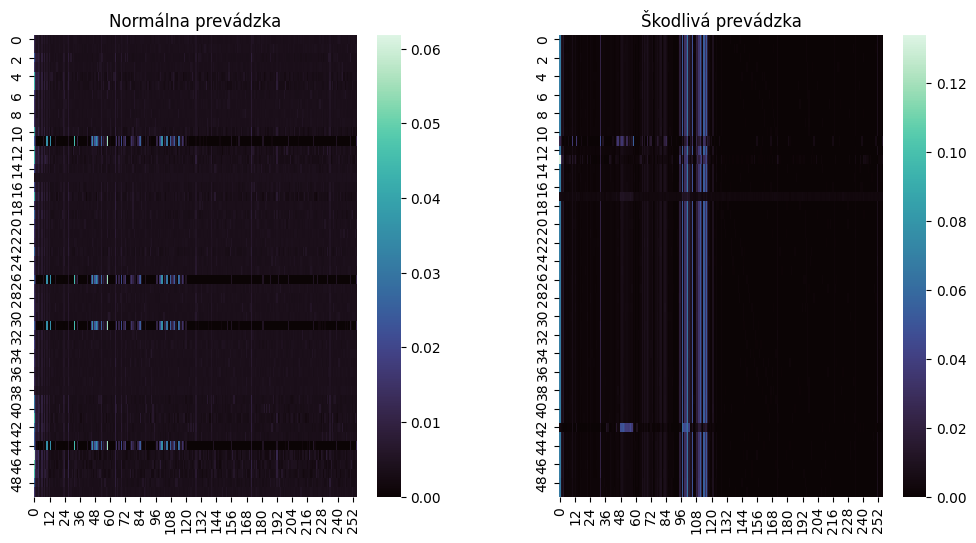

In [203]:
def get_distro(filename):
    streamer = NFStreamer(source=path+filename, udps=PayloadCollector())
    distro = []
    for flow in streamer:
        distro.append(flow.udps.payload_byte_distro)
    return np.array(distro)
def plot_distro(distro, ax):
    sns.heatmap(distro[100:150], cmap="mako", cbar=True, ax = ax)
encr_flows_distro = get_distro(filename)
plain_flows_distro = get_distro('classification/sql-injection.pcap')
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('Normálna prevádzka')
ax[1].set_title('Škodlivá prevádzka')

plot_distro(encr_flows_distro, ax=ax[0])
plot_distro(plain_flows_distro, ax=ax[1])
fig.show()

In [206]:
streamer = NFStreamer(source=benign_path, udps=PayloadCollector())
df = streamer.to_pandas()
df.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,udps.payload_byte_distro
0,0,0,172.27.0.6,02:42:ac:1b:00:06,02:42:ac,58340,172.27.0.4,02:42:ac:1b:00:04,02:42:ac,3306,...,MySQL,Database,0,6,NaN,NaN,NaN,NaN,NaN,[0.0457351 0.01072549 0.00708287 0.01133259 0...
1,1,0,172.27.0.6,02:42:ac:1b:00:06,02:42:ac,42378,172.27.0.2,02:42:ac:1b:00:02,02:42:ac,6379,...,TLS,Web,0,6,redis,a468eae2a82cd86fea9fd0c541ed8ff0,15af977ce25de452b96affa2addb1036,NaN,NaN,[0.00662073 0.00458233 0.00434588 0.00454156 0...
2,2,0,172.27.0.6,02:42:ac:1b:00:06,02:42:ac,36564,172.27.0.4,02:42:ac:1b:00:04,02:42:ac,3306,...,MySQL,Database,0,6,NaN,NaN,NaN,NaN,NaN,[0.012163 0.00635771 0.00474485 0.00642183 0...
3,3,0,172.27.0.6,02:42:ac:1b:00:06,02:42:ac,58514,172.27.0.4,02:42:ac:1b:00:04,02:42:ac,3306,...,MySQL,Database,0,6,NaN,NaN,NaN,NaN,NaN,[0.00936343 0.00563233 0.00528276 0.00578571 0...
4,4,0,172.27.0.6,02:42:ac:1b:00:06,02:42:ac,36566,172.27.0.4,02:42:ac:1b:00:04,02:42:ac,3306,...,MySQL,Database,0,6,NaN,NaN,NaN,NaN,NaN,[0.01248238 0.00660919 0.00523657 0.00663863 0...


In [205]:
df[10]

KeyError: 10

## NFPlugin to extract payload bytes distribution

In [368]:
import collections
bytes_distro = []
class PayloadCollector(NFPlugin):
    def __init__(self):
        self.analyzer = analyzer
    @staticmethod
    def _extend_flow_payload(packet, flow):
        if packet.payload_size > 0:
            payload = packet.ip_packet
            flow.udps.payload_encodings.append(payload)
            byte_counter = collections.Counter(payload)
            flow.udps.payload_byte_distro += [byte_counter.get(byte, 0) for byte in range(256)]\

    def on_init(self, packet, flow):
        flow.udps.payload_byte_distro = np.zeros(256)
        flow.udps.payload_encodings = []
        self._extend_flow_payload(packet, flow)

    def on_update(self, packet, flow):  
        self._extend_flow_payload(packet, flow)
    def on_expire(self, flow):
        flow.udps.payload_byte_distro = flow.udps.payload_byte_distro/max(1, sum(flow.udps.payload_byte_distro))

## Metadata dataset class
Accepts preprocessed numpy array and converts it to tensors. 
Output: tensor of shape __N of flows, 1, 74__

In [147]:
class FlowDataset(Dataset):
  def __init__(self, flows, transforms = None):
    self.flows = flows
    # ts = self.flows.groupby(timestamp_col)
    self.transform = transforms
    self.flows = torch.tensor(self.flows).unsqueeze(1)

  def __getitem__(self, idx):
      sample = self.flows[idx]
      if self.transform:
            sample = self.transform(sample)
      return sample

  def __len__(self):
    return len(self.flows)


In [27]:
class AppendPayloadDistro(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_temp = X.copy()
    
        columns = ['byte_' + str(i) for i in range(256)]
        distro = []
        distros = X_temp['udps.payload_byte_distro']
        
        for d in distros:
            values = d.strip('[]').split()
            distro.append(list(map(float, values)))
    
        X_temp = X_temp.drop(columns = ['udps.payload_byte_distro'])

        distro_df = pd.DataFrame(distro, columns = columns)
        
        return pd.concat([X_temp.reset_index(drop=True), distro_df], axis=1)

## Assigning datasets

__flow_df__ - flow-based properties - 63 features
__packet_df__ - packet-based payload bytes distribution - 256 features

In [299]:
batch_size = 32
# flows = 0
columns = [
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 
       'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
        'dst2src_duration_ms', 'src_port', 'dst_port', 
       'dst2src_packets', 'dst2src_bytes', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps',
       'src2dst_stddev_ps', 'src2dst_max_ps', 'dst2src_min_ps',
       'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'src2dst_max_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
       'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms',
       'bidirectional_syn_packets', 'bidirectional_cwr_packets',
       'bidirectional_ece_packets', 'bidirectional_urg_packets',
       'bidirectional_ack_packets', 'bidirectional_psh_packets',
       'bidirectional_rst_packets', 'bidirectional_fin_packets',
       'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
       'src2dst_urg_packets', 'src2dst_ack_packets', 'src2dst_psh_packets',
       'src2dst_rst_packets', 'src2dst_fin_packets', 'dst2src_syn_packets',
       'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
       'dst2src_ack_packets', 'dst2src_psh_packets', 'dst2src_rst_packets',
       'dst2src_fin_packets']
ct = ColumnTransformer([
    ('scaler', StandardScaler(), columns)
], remainder='passthrough')

pipeline = Pipeline(steps= [
        ('dropper', DropExcessCols(to_drop)),
        ('time_to_log', TimestampsToLog(ms_columns)),
        ('distro', AppendPayloadDistro()),
        ('scaler', MinMaxScaler())
    ])
def preprocess(filename, pipeline, fit=False):
    streamer = NFStreamer(source = filename, statistical_analysis=True, udps = PayloadCollector())
    flows = streamer.to_pandas()
    
    flows = flows[flows['ip_version'] == 4]
    if fit: pipeline = pipeline.fit(flows)
    
    return pipeline.transform(flows)
    
flow_train_df = preprocess(path + filename, pipeline, True)
flow_val_df_positive = preprocess(path+val_filename_positive, pipeline, False)
flow_val_df_negative = preprocess(sql_inj_path, pipeline, False)

flow_train_dataset = FlowDataset(flow_train_df)
flow_val_dataset_positive = FlowDataset(flow_val_df_positive)
flow_val_dataset_negative = FlowDataset(flow_val_df_negative)

flow_train_loader = DataLoader(flow_train_dataset, batch_size=batch_size)
flow_val_loader_positive = DataLoader(flow_val_dataset_positive, batch_size=batch_size)
flow_val_loader_negative = DataLoader(flow_val_dataset_negative, batch_size=batch_size)




116808
116808
116808


In [302]:
streamer = NFStreamer(source = path + filename, statistical_analysis=True, udps = PayloadCollector())
flows = streamer.to_pandas()


In [305]:
streamer = NFStreamer(source = path + 'test_26.pcapng', statistical_analysis=True, udps = PayloadCollector())
flows_test = streamer.to_pandas()

In [307]:
flows['bidirectional_bytes']

0         11013
1        124327
2        209156
3        287460
4        280837
         ...   
6522     717571
6523       5181
6524    2774317
6525     717505
6526     717360
Name: bidirectional_bytes, Length: 6527, dtype: int64

In [298]:
pipeline['scaler'].get_feature_names_out()

array(['src_port', 'dst_port', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes',
       'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps',
       'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
       'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'src2dst_max_piat_ms', 'dst2src_min_piat_ms',
       'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'bidirectional_syn_packets',
       'bidirectional_cwr_packets', 'bidirectional_ece_packets',
       'bidirectio

In [308]:
flow_input_dim = flow_train_df.shape[1]


print(f'Total samples train: {len(flow_train_df)}')
print(f'Total samples val_positive: {len(flow_val_df_positive)}')
print(f'Total samples val_negative: {len(flow_val_df_negative)}')
print(f'Flow input dim: {flow_input_dim}')

print(f'Total batches train: {len(flow_train_loader)}')
print(f'Total batches val positive: {len(flow_val_loader_positive)}')
print(f'Total batches val negative: {len(flow_val_loader_negative)}')
print(f'Flow train loader batch shape: {next(iter(flow_train_loader)).shape}')

Total samples train: 5330
Total samples val_positive: 1043
Total samples val_negative: 312
Flow input dim: 315
Total batches train: 167
Total batches val positive: 33
Total batches val negative: 10
Flow train loader batch shape: torch.Size([32, 1, 315])


In [296]:
flow_tensors_val_positive[1][0]

tensor([     0.4759,     -1.7045,      0.0957,     -0.3824,     -0.5602,
             1.1769,      0.0957,     -0.3821,     -0.0763,      0.1555,
            -0.3819,     -0.5867,     -0.0213,     -0.6832,     -0.7725,
            -0.6205,     -0.0765,      0.0106,     -0.0982,     -0.0929,
             0.1840,     -0.6947,     -0.7867,     -0.6192,     -0.0896,
             0.0333,      0.2741,      0.3143,     -0.0898,      0.0959,
             0.3391,      0.3142,     -0.0409,      0.2270,      0.4529,
             0.3643,     -0.0127,      0.0000,      0.0000,      0.0000,
            -0.3818,     -0.2703,      1.5323,     -3.1559,     -0.0211,
             0.0000,      0.0000,      0.0000,     -0.3814,     -0.0483,
            -0.0604,     -3.5666,      0.0034,      0.0000,      0.0000,
             0.0000,     -0.3815,     -0.4039,      1.5695,     -2.1714,
            -0.0257,      0.1214,      0.2023,      0.3312,      1.5370,
             0.7270,     -0.0892,     -0.0380,     

## Plot benign and sql injection vectors

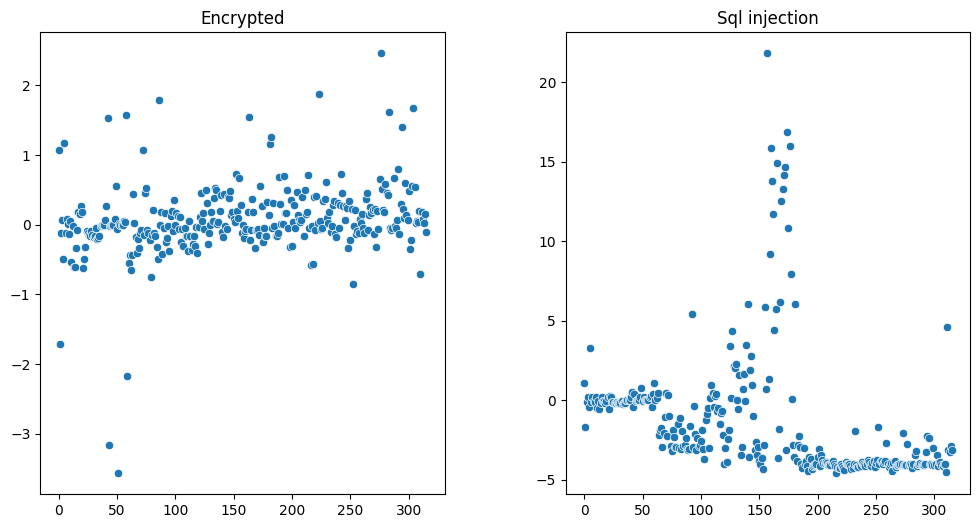

In [297]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('Encrypted')
ax[1].set_title('Sql injection')

sns.scatterplot(flow_tensors_val_positive[4][0], ax = ax[0])
sns.scatterplot(flow_tensors_val_negative[1][0], ax = ax[1])

fig.show()


In [287]:
flow_tensors_val_positive[20]

tensor([[     1.3947,     -3.6993,     -0.0434,     -0.5557,     -0.5704,
              1.1775,     -0.0434,     -0.5673,     -0.0941,     -0.0495,
             -0.5424,     -0.5941,     -0.0213,     -0.6673,     -0.6631,
             -0.5562,     -0.0765,      0.1224,      0.1061,     -0.0721,
              0.1840,     -0.6902,     -0.5914,     -0.5542,     -0.0896,
              0.0722,     -0.0508,     -0.1341,     -0.0898,      0.1954,
             -0.0724,     -0.1299,     -0.0409,      0.2253,     -0.0490,
             -0.1135,     -0.0127,      0.0000,      0.0000,      0.0000,
             -0.5551,     -0.5078,     -0.4214,      0.3748,     -0.0211,
              0.0000,      0.0000,      0.0000,     -0.5665,     -0.3169,
             -0.0604,      0.2021,      0.0034,      0.0000,      0.0000,
              0.0000,     -0.5420,     -0.5965,     -0.4157,      0.4096,
              0.6229,      2.4688,      1.2132,      1.7035,      3.9389,
              3.3550,      3.8150,    

In [339]:
joblib.dump(pipeline, 'ae_pipeline_final.gz')

['ae_pipeline_final.gz']

## Mean and std calculation

In [143]:
# flow_loader = DataLoader(flow_df, batch_size=1000)
# # packet_loader = DataLoader(packet_df, batch_size=1000)
# def get_mean_std(loader, n_features, df):
#     num_samples = 0
#     for d in df:
#         num_samples += d.shape[0]
#     total_length = num_samples * n_features
#     total_sum = 0
#     for batch in loader: 
#         total_sum += batch.sum()
#     mean = total_sum/total_length
#     sse = 0 # sum of squared error
#     for batch in loader:
#         sse += ((batch - mean).pow(2)).sum()
#     std = torch.sqrt(sse/total_length)
#     return mean, std

# flow_mean, flow_std = get_mean_std(flow_loader, flow_input_dim, flow_df)
# # packet_mean, packet_std = get_mean_std(packet_loader, packet_input_dim, packet_df)
# print(f'Flow mean: {flow_mean}, std: {flow_std}')
# # print(f'Packet mean: {packet_mean}, std: {packet_std}')
# flow_tr = torchvision.transforms.Compose([
#     torchvision.transforms.Normalize(flow_mean, flow_std)
# ])
# flow_df.transform = flow_tr
# flow_val_df_positive.transform = flow_tr
# flow_val_df_negative.transform = flow_tr


In [144]:
# class FlowNormalizer:
#     def __init__(self, mean, std):
#         self.mean = mean
#         self.std = std
#         self.normalizer = torchvision.transforms.Normalize(mean=self.mean, std=self.std)

#     def normalize(self, tensor_input):
#         return self.normalizer(tensor_input)
    
#     def get_mean_std(self):
#         return self.mean, self.std



In [145]:
# normalizer = FlowNormalizer(flow_mean, flow_std)
# torch.save(normalizer, 'ae_normalizer.pth')

## Check validation set mean and std
As we apply the same normalization to train and real data, let's check how far from normal (mean = 0 and std = 1) are validation values

In [146]:
# loader = DataLoader(flow_val_df_positive, batch_size = len(flow_df))
# data = next(iter(loader))
# for d in data.permute(1, 0, 2)[0]:
#     # print(d[11])
#     if d.sum() == -np.inf:
#         print(d)
# data.permute(1, 0, 2)[0].mean(), data.permute(1, 0, 2)[0].std()

## LSTM based autoencoder
The Autoencoder has 2 LSTM layers and 2 Linear layers dividing them

In [151]:
class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout = 0, device = 'cpu'):
        super(Encoder, self).__init__()
        self.device = device
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # print("Encoder device: " + str(device))
        self.lstm = nn.LSTM(input_size = nb_feature, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout, bias = True).to(device)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )
    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell
        
class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # print("Decoder device: " + str(device))
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True).to(device)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature).to(device)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell
        
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)
        # print("Main device: " + str(device))

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float).to(self.device)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output

## Custom R2 function

In [152]:
def r2_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    y_mean = torch.mean(y_true)

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    
    r2 = 1 - ss_res / (ss_tot + 1e-8) 
    
    return r2.item()


## Training loop
- Loss should go down
- R2 should go up
- validation_loss_positive should go down (model performance on "unseen" encrypted flows)
- validation_loss_negative should stay high as we validate on unencrypted payload

In [165]:
epochs = 50
learning_rate = 1e-4

# criterion = nn.SmoothL1Loss(reduction='sum').to(device)
criterion = nn.MSELoss().to(device)
# metric = R2Score().to(device)

def train_one_epoch(model, loader, optimizer, val = False):
    running_loss = 0.
    r2 = []
    for i, batch in enumerate(loader):
        inputs = batch.float().permute(1, 0, 2).to(device)
        if not val: 
            optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        if not val:
            loss.backward() 
            optimizer.step()
        running_loss += loss.item()
        
        r2.append(r2_score(inputs, outputs))
    running_loss = running_loss / len(loader)
    r2 = np.array(r2)
    return running_loss, np.mean(r2)

def training_loop(model, train_loader, val_loader_positive, val_loader_negative, history, epochs = 50):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print('Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val')
    for epoch in range(epochs):
        model.train()
        training_loss, r2_train = train_one_epoch(model, train_loader, optimizer)
        model.eval() 
        val_loss = []
        with torch.no_grad(): 
            val_loss_negative, _ = train_one_epoch(model, val_loader_negative, optimizer, val = True)
            val_loss_positive, r2_val = train_one_epoch(model, val_loader_positive, optimizer, val = True)
        history.append({'loss': training_loss, 'r2_train': r2_train, 'r2_val': r2_val, 'val_loss_negavtive': val_loss_negative, 'val_loss_positive': val_loss_positive})
        print(f'{epoch + 1} | {training_loss} | {val_loss_positive} | {val_loss_negative} | {r2_train} | {r2_val}')
    return history

## Train autoencoder

In [309]:
flow_ae = LSTMAutoEncoder(num_layers = 1, hidden_size = 20, nb_feature = flow_input_dim, device = device).to(device)
flow_history = []

In [310]:

# flow_history = np.open('history')
training_loop(flow_ae,
              train_loader = flow_train_loader, 
              val_loader_positive = flow_val_loader_positive,
              val_loader_negative = flow_val_loader_negative,
              history = flow_history, 
              epochs = 90
             )

Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val
1 | 0.11371137340090232 | 0.08026294681158933 | 0.11426959410309792 | -2.146530923729171 | -1.2703250321474941
2 | 0.050056722461284994 | 0.024670829714247673 | 0.11999322026968003 | -0.38445893162024947 | 0.3021489598534324
3 | 0.016510149558816484 | 0.01053335207204024 | 0.12165683880448341 | 0.5454377300011184 | 0.7022212328332843
4 | 0.01009331112671755 | 0.008568853915979465 | 0.1227960579097271 | 0.7234887277294776 | 0.7578408934853293
5 | 0.0091490170076311 | 0.008279176922797254 | 0.12327680066227913 | 0.7496898895252251 | 0.7660438526760448
6 | 0.008981965250798507 | 0.008233981588008728 | 0.12338286191225052 | 0.7543200272286009 | 0.7673235607869697
7 | 0.008948335488198582 | 0.008230587566327868 | 0.12337769269943237 | 0.7552495024161424 | 0.7674188884821805
8 | 0.008940417021178378 | 0.008232667717631117 | 0.12337453737854957 | 0.7554667877579877 | 0.7673587311397899


KeyboardInterrupt: 

In [311]:
with open('ae_train.npy', 'wb') as f:
    np.save(f, flow_history)
    # np.save(f, np.array([1, 3]))

In [250]:
history_df = pd.DataFrame(flow_history)
history_df.to_csv('flow_history.csv', sep='\t')

## Plotting loss 
After trying training on small subsets, we will now see how loss was changing and tweak model parameters

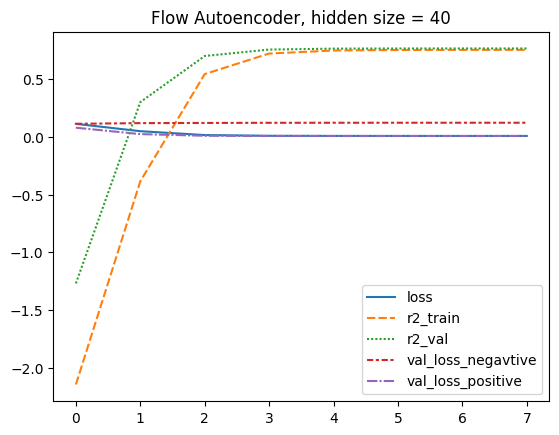

In [312]:
flow_history = np.load('ae_train.npy', allow_pickle=True)
# list(flow_history)
stats = pd.DataFrame(list(flow_history))
# stats
sns.lineplot(stats).set_title("Flow Autoencoder, hidden size = 40")
plt.savefig('flow_ae_final.png')

In [338]:
# flow_ae.pth packet_ae, packet_ae1
torch.save(flow_ae, path + 'ae_final.pth')

tensor(0.4926, device='xpu:0')


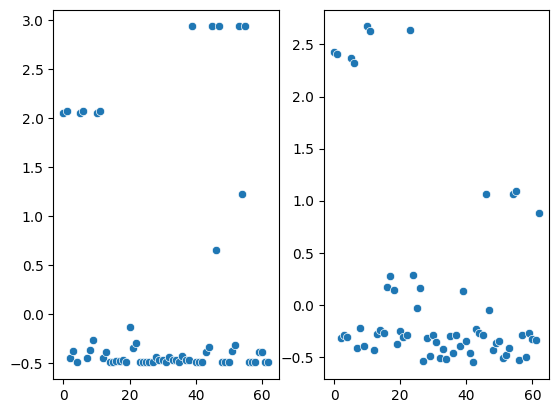

In [302]:
values = next(iter(flow_val_loader_negative)).float().permute(1, 0, 2).to(device)
i = 20
pred = packet_model(values).detach()[0][i]
# print(values[0][0])
# print(pred[0][0])
fig, ax = plt.subplots(1,2)
sns.scatterplot(values[0][i].cpu(), ax = ax[0])
sns.scatterplot(pred.cpu(), ax = ax[1])

fig.show()
# print(values[0][i])
print((values[0][i] - pred).sum())

In [212]:
attacks = {
    'BENIGN': 1,
    'SQL_INJ': 5,
    'XSS': 6,
    'DDOS': 7,
    'PORTSCAN': 8
}

## Create dataset for attacks classifier

In [340]:
ae = torch.load(path + 'ae_final.pth', map_location=device, weights_only=False)
# ae_normalizer = torch.load('models/ae_normalizer.pth', weights_only=False)
ae_pipeline = joblib.load('ae_pipeline_final.gz')
ae.device = torch.device("cpu")
# ae.encoder.device = torch.device("cpu")
# ae.decoder.device = torch.device("cpu")

In [352]:
benign_path = path + 'classification/benign.pcap'
sql_inj_path = path + 'classification/sql_inj-27.pcap'
xss_path = path + 'classification/xss.pcapng'
ddos_path = path + 'classification/ddos'
# plain_redis_path = path + 'classification/plain-redis.pcap'
portscan_path = path + 'classification/portscan/part'
# redis_warning_response = 'classification/warning_redis_response.pcapng'
# plain_sql_path = path + 'classification/plain_mysql.pcap'
# plain_pass_path = path + 'classification/secure-data-http.pcapng'

    
def prepare_input(filename, pipeline):
    data = preprocess(filename, pipeline)
    data_tensors = torch.tensor(np.array(data)).unsqueeze(1)
    columns = [f.replace('scaler__', '').replace('remainder__', '') for f in pipeline['scaler'].get_feature_names_out()]
    return data_tensors, columns
    
def to_pandas(dataset, label, columns):
    data = [] 
    # columns = list(columns)
    columns.append('label')
    for flow in dataset:
        new_flow = flow.view(-1).numpy()
        data.append([*new_flow, label])
    return pd.DataFrame(data, columns = columns)
    
def get_df(filename, label, pipeline):
    packets, columns = prepare_input(filename, pipeline)
    packets = packets.float().to(device)
    predictions = ae(packets).detach()
    rows = np.abs(packets.cpu() - predictions.cpu())
    return to_pandas(rows, label, columns)

def divide_df(df, train_size = 0.8, shuffle = True):
    X_train, X_test = train_test_split(df, train_size = train_size, shuffle = shuffle)
    X_test, X_val = train_test_split(X_test, train_size = 0.8, shuffle = shuffle)
    return X_train, X_test, X_val

def create_datasets(filemap):
    train = []
    test = []
    val = []
    for label, filename in filemap:
        print(filename)
        df = get_df(filename, label, ae_pipeline)
        train_tmp, test_tmp, val_tmp = divide_df(df)
        train.append(train_tmp)
        test.append(test_tmp)
        val.append(val_tmp)
    return pd.concat(train, axis = 0), pd.concat(test, axis = 0), pd.concat(val, axis = 0)

filemap = [
    (attacks['BENIGN'], benign_path),
    (attacks['SQL_INJ'], sql_inj_path),
    (attacks['XSS'], xss_path),
    (attacks['DDOS'], ddos_path),
    # (attacks['PLAIN_REDIS'], plain_redis_path),
    # (attacks['PLAIN_SQL'], plain_sql_path),
    # (attacks['PLAIN_PASS'], plain_pass_path),
    (attacks['PORTSCAN'], portscan_path)
]

train, test, val = create_datasets(filemap)        

/jupyter/shared/../datasets/classification/benign.pcap
128
/jupyter/shared/../datasets/classification/sql-injection.pcap
128
/jupyter/shared/../datasets/classification/xss.pcapng
128
/jupyter/shared/../datasets/classification/ddos
128
/jupyter/shared/../datasets/classification/portscan/part
128


## Save into CSV

In [ ]:
benign_path = path + 'classification/benign.pcap'
sql_inj_path = path + 'classification/sql_inj-27.pcap'
xss_path = path + 'classification/xss.pcapng'
ddos_path = path + 'classification/ddos'
# plain_redis_path = path + 'classification/plain-redis.pcap'
portscan_path = path + 'classification/portscan/part'
# redis_warning_response = 'classification/warning_redis_response.pcapng'
# plain_sql_path = path + 'classification/plain_mysql.pcap'
# plain_pass_path = path + 'classification/secure-data-http.pcapng'

dropper = DropExscessColumns(to_drop)
    
def prepare_input(filename, pipeline):
    encodings = flow.udps.payload_encodings
    del flow.udps
    data = list(zip(flow.keys(), flow.values()))
    filtered = {}
    for ix, val in data:
        filtered[ix] = []
        if isinstance(val, array.array) or isinstance(val, np.ndarray):
            filtered[ix].append('[' + ' '.join(map(str, val)) + ']')
        else:
            filtered[ix].append(val)
    data = pd.DataFrame(filtered)
    data_tensors = torch.tensor(np.array(data)).unsqueeze(1)
    columns = [f.replace('scaler__', '').replace('remainder__', '') for f in pipeline['scaler'].get_feature_names_out()]
    return data_tensors, columns
    
def to_pandas(dataset, label, columns):
    data = [] 
    # columns = list(columns)
    columns.append('label')
    for flow in dataset:
        new_flow = flow.view(-1).numpy()
        data.append([*new_flow, label])
    return pd.DataFrame(data, columns = columns)
    
def get_df(filename, label, pipeline):
    packets, columns = prepare_input(filename, pipeline)
    packets = packets.float().to(device)
    predictions = ae(packets).detach()
    rows = np.abs(packets.cpu() - predictions.cpu())
    return to_pandas(rows, label, columns)

def divide_df(df, train_size = 0.8, shuffle = True):
    X_train, X_test = train_test_split(df, train_size = train_size, shuffle = shuffle)
    X_test, X_val = train_test_split(X_test, train_size = 0.8, shuffle = shuffle)
    return X_train, X_test, X_val

def create_datasets(filemap):
    train = []
    test = []
    val = []
    for label, filename in filemap:
        print(filename)
        df = get_df(filename, label, ae_pipeline)
        train_tmp, test_tmp, val_tmp = divide_df(df)
        train.append(train_tmp)
        test.append(test_tmp)
        val.append(val_tmp)
    return pd.concat(train, axis = 0), pd.concat(test, axis = 0), pd.concat(val, axis = 0)

filemap = [
    (attacks['BENIGN'], benign_path),
    (attacks['SQL_INJ'], sql_inj_path),
    (attacks['XSS'], xss_path),
    (attacks['DDOS'], ddos_path),
    (attacks['PORTSCAN'], portscan_path)
]

train, test, val = create_datasets(filemap)        

In [374]:
ddos_example = test[test['label'] == attacks['DDOS']][0:1]
xss_example = test[test['label'] == attacks['XSS']][0:1]
sql_example = test[test['label'] == attacks['SQL_INJ']][0:1]
portscan_example = test[test['label'] == attacks['PORTSCAN']][0:1]

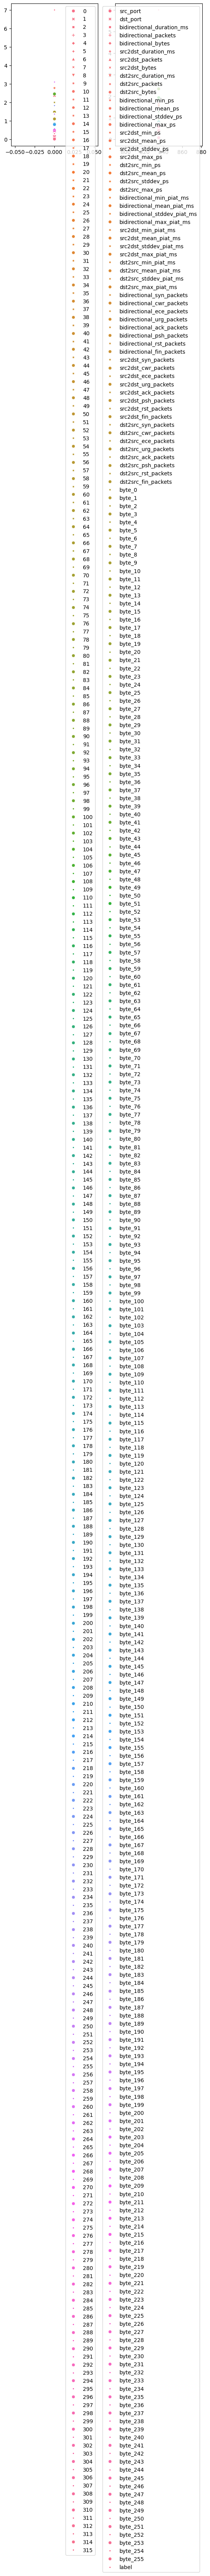

In [380]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(ddos_example.values, ax = ax[0])
sns.scatterplot(xss_example, ax = ax[1])
# sns.scatterplot(sql_example, ax = ax[2])
# sns.scatterplot(portscan_example, ax = ax[3])
fig.show()

In [358]:
train.reset_index(drop=True).to_csv(path + 'attacks_train.csv', index=False)
# train_y.reset_index(drop=True).to_csv(path + 'attacks_train_y.csv', index=False)
test.reset_index(drop=True).to_csv(path + 'attacks_test.csv', index=False)
val.reset_index(drop=True).to_csv(path + 'attacks_val.csv', index=False)
# test_y.reset_index(drop=True).to_csv(path + 'attacks_test_y.csv', index=False)

## Load and set dimensions

In [28]:
class AttackDataset(Dataset):
  def __init__(self, filename, transforms = None):
    self.df = pd.read_csv(filename)
    self.transform = transforms

  def __getitem__(self, idx):
      sample = self.df.iloc[idx, :-1]
      label = self.df.iloc[idx, -1:]
      return torch.tensor(sample.to_numpy()), torch.tensor(label.to_numpy())

  def __len__(self):
    return self.df.shape[0]


In [51]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
attack_train = AttackDataset(path + 'attacks_train.csv', transforms = transforms)
# train_y = AttackDataset(path + 'attacks_train_y.csv', transforms = transforms)
attack_test = AttackDataset(path + 'attacks_test.csv', transforms = transforms)
attack_val = AttackDataset(path + 'attacks_val.csv', transforms = transforms)
# test_y = AttackDataset(path + 'attacks_test_y.csv', transforms = transforms)
attack_input_dim = attack_train[0][0].shape[0]
attack_output_dim = 1
print(f'Input dim: {attack_input_dim}, output dim: {attack_output_dim}')

Input dim: 313, output dim: 1


In [30]:
attack_train_loader = DataLoader(attack_train, batch_size=64)
attack_val_loader = DataLoader(attack_val, batch_size=64)

## Create classifier

In [315]:
class AttackClassifier(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AttackClassifier, self).__init__()
        self.layer1 = nn.Linear(in_dim, 10)
        self.relu = nn.ReLU()
        # self.layer2 = nn.Linear(120, 10)
        self.layer2 = nn.Linear(10, out_dim)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x
        return x

In [345]:
attack_classifier = AttackClassifier(attack_input_dim, attack_output_dim).to(device)

## Training classifier

Labels shape: torch.Size([64, 1]), pred shape: torch.Size([64, 1])
0.6429697861894965


In [ ]:
flow_history = np.load('attack_train.npy', allow_pickle=True)
# list(flow_history)
stats = pd.DataFrame(list(attack_history))
# stats
sns.lineplot(stats).set_title("Attack classifier")
plt.savefig('flow_ae_final.png')

In [359]:
df = pd.read_csv(path + 'attacks_train.csv').sample(frac=1)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1:]

In [360]:
df_test = pd.read_csv(path + 'attacks_test.csv').sample(frac=1)
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]

In [361]:
df['label'].value_counts()
classifier = KNeighborsClassifier()

In [362]:
X_test.shape

(2821, 315)

In [369]:
# from sklearn.model_selection import GridSearchCV
# classifier = KNeighborsClassifier()
# params = {
#     'n_neighbors': [3, 5, 6, 7],
#     'weights': ('uniform', 'distance'),
#     'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
#     'leaf_size': [5,10,20,30,35,40],
#     'metric': ('manhattan', 'minkowski')
# }
# gs = GridSearchCV(classifier, params)
# gs.fit(X_train, y_train.to_numpy().ravel())
# print("Best Parameters:", gs.best_params_)
# print("Best Cross-Validation Accuracy:", gs.best_score_)

In [363]:
from sklearn.metrics import classification_report
classifier = KNeighborsClassifier(leaf_size=5, n_neighbors= 3)
classifier.fit(X_train.values, y_train.to_numpy().ravel()) 
pred = classifier.predict(X_test.values)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       136
           5       1.00      0.96      0.98        50
           6       1.00      1.00      1.00       414
           7       1.00      1.00      1.00       221
           8       1.00      1.00      1.00      2000

    accuracy                           1.00      2821
   macro avg       1.00      0.99      0.99      2821
weighted avg       1.00      1.00      1.00      2821



In [365]:
joblib.dump(classifier, 'models/att_classifier_final.gz')

['models/att_classifier_final.gz']

In [367]:
classifier.n_features_in_

315

In [336]:
import array
streamer = NFStreamer(source=portscan_path, statistical_analysis=True, udps=PayloadCollector())

suspicious_packets = 0
total_packets = 0
for flow in streamer:
    data = list(zip(flow.keys(), flow.values()))
    filtered = {}
    for ix, val in data:
        filtered[ix] = []
        if isinstance(val, array.array) or isinstance(val, np.ndarray):
            filtered[ix].append('[' + ' '.join(map(str, val)) + ']')
        else:
            filtered[ix].append(val)
    data = pd.DataFrame(filtered)
    
    transformed = pipeline.transform(data) 
    transformed = torch.tensor(np.array(transformed)).unsqueeze(1).to(device)
    predictions = flow_ae(transformed.float()).detach()
    # distance = np.abs(transformed.cpu() - predictions.cpu())
    # attack = classifier.predict(distance[0])
    error = np.mean(np.square(transformed.cpu() - predictions.cpu())[0][0].numpy())
    # attack_l = ' '.join(map(str, attack))
    print(f'Error: {error}')
    if error > 0.085:
        suspicious_packets = suspicious_packets + 1
        # break
    total_packets = total_packets + 1
print(f'Total packets: {total_packets}, suspicious: {suspicious_packets}')
# fig, ax = plt.subplots(1,2)
# sns.scatterplot(transformed.cpu()[0][0], ax = ax[0])
# sns.scatterplot(predictions.cpu()[0][0], ax = ax[1])

# fig.show()
#     transformed = ae_normalizer.normalize(torch.tensor(np.array(transformed)).unsqueeze(1))
#     
#     error = np.mean(np.square(predictions - transformed)[0][0].numpy())
#     print(error)

Error: 0.030262600551612936
Error: 0.03324697502237843
Error: 0.1392057619616272
Error: 0.049470771886442916
Error: 0.1071009638552654
Error: 0.026728026073787256
Error: 0.02380739533224727
Error: 0.026006031761016134
Error: 0.03237436515273531
Error: 0.02877440638113336
Error: 0.07424462103093658
Error: 0.030807804290499733
Error: 0.029356380510608307
Error: 0.16680425091921436
Error: 0.031753813407536136
Error: 0.032117334476670756
Error: 0.02756799224610605
Error: 0.033781749632853096
Error: 0.027100921629797912
Error: 0.025328797081561875
Error: 0.1982068687336139
Error: 0.16431128373324927
Error: 0.030201929197093868
Error: 0.06865016671759808
Error: 0.10844798977344008
Error: 0.03024549878107534
Error: 0.030995604027206428
Error: 0.02921814415751713
Error: 0.03016869611278695
Error: 0.026963242161863448
Error: 0.02915257220823515
Error: 0.03159806337109045
Error: 0.02781491092326596
Error: 0.028357929416878126
Error: 0.03265712856294478
Error: 0.04636502213120734
Error: 0.0260189

Process ForkProcess-1563:
Process ForkProcess-1565:
Process ForkProcess-1561:
Process ForkProcess-1564:
Process ForkProcess-1566:
Process ForkProcess-1562:
Process ForkProcess-1568:
Process ForkProcess-1567:
Process ForkProcess-1569:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in 

Error: 0.028321774300625397
Error: 0.03367352550404609
Error: 0.1368209984786931
Error: 0.20579201716362208
Error: 0.06987697901018072
Error: 0.10229656696844665
Error: 0.038283580699417036
Error: 0.04729976547326147


  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "

KeyboardInterrupt: 

  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.10/multipr

In [337]:
for floe in streamer:
    print(floe)
    break

NFlow(id=0,
      expiration_id=0,
      src_ip=172.25.0.1,
      src_mac=02:42:42:93:72:2a,
      src_oui=02:42:42,
      src_port=41478,
      dst_ip=172.25.0.8,
      dst_mac=02:42:ac:19:00:08,
      dst_oui=02:42:ac,
      dst_port=5900,
      protocol=6,
      ip_version=4,
      vlan_id=0,
      tunnel_id=0,
      bidirectional_first_seen_ms=1736600483240,
      bidirectional_last_seen_ms=1736600483240,
      bidirectional_duration_ms=0,
      bidirectional_packets=2,
      bidirectional_bytes=128,
      src2dst_first_seen_ms=1736600483240,
      src2dst_last_seen_ms=1736600483240,
      src2dst_duration_ms=0,
      src2dst_packets=1,
      src2dst_bytes=74,
      dst2src_first_seen_ms=1736600483240,
      dst2src_last_seen_ms=1736600483240,
      dst2src_duration_ms=0,
      dst2src_packets=1,
      dst2src_bytes=54,
      bidirectional_min_ps=54,
      bidirectional_mean_ps=64.0,
      bidirectional_stddev_ps=14.142135623730951,
      bidirectional_max_ps=74,
      src2dst_min_

In [272]:
ae_pipeline['scaler'].get_feature_names_out()

array(['src_port', 'dst_port', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes',
       'src2dst_first_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets',
       'dst2src_bytes', 'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps',
       'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
       'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
       'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'src2dst_max_piat_ms', 'dst2src_min_piat_ms',
       'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms',
       'dst2src_max_piat_ms', 'bidirectional_syn_packets',
       'bidirectional_cwr_packets', 'bidirectional_ece_pac

In [277]:
print(flow_test)

NFlow(id=0,
      expiration_id=0,
      src_ip=172.30.0.5,
      src_mac=02:42:ac:1e:00:05,
      src_oui=02:42:ac,
      src_port=41038,
      dst_ip=172.30.0.6,
      dst_mac=02:42:ac:1e:00:06,
      dst_oui=02:42:ac,
      dst_port=3306,
      protocol=6,
      ip_version=4,
      vlan_id=0,
      tunnel_id=0,
      bidirectional_first_seen_ms=1737918106447,
      bidirectional_last_seen_ms=1737918114359,
      bidirectional_duration_ms=7912,
      bidirectional_packets=225,
      bidirectional_bytes=136183,
      src2dst_first_seen_ms=1737918106447,
      src2dst_last_seen_ms=1737918114359,
      src2dst_duration_ms=7912,
      src2dst_packets=121,
      src2dst_bytes=39080,
      dst2src_first_seen_ms=1737918106447,
      dst2src_last_seen_ms=1737918114359,
      dst2src_duration_ms=7912,
      dst2src_packets=104,
      dst2src_bytes=97103,
      bidirectional_min_ps=66,
      bidirectional_mean_ps=605.257777777778,
      bidirectional_stddev_ps=946.0162549779682,
      bidirect